In [27]:
from diffusers import UNet2DClassConditionModel, DDPMScheduler
import torch
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [37]:
# classifier-free inference
from diffusers.utils import randn_tensor
from diffusers import DDPMScheduler,DDIMScheduler, UNet2DClassConditionModel

unet = UNet2DClassConditionModel.from_pretrained(
    "results/xray_64/checkpoint-15000/unet_ema"
)
unet.load_state_dict(torch.load("results/xray_64/unet.pt"))
unet = unet.to(device="cuda")


class_labels = torch.tensor(
    [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2],
    device="cuda",
    dtype=torch.long,
)
class_null = torch.tensor([3] * 12, device="cuda", dtype=torch.long).reshape(-1)
image = randn_tensor(
    (12, 3, 64, 64),
    device="cuda",
    dtype=torch.float32,
)
class_labels_input = torch.cat([class_labels, class_null], 0)
model_input = torch.cat([image] * 2)

latent_channels = unet.config.in_channels
unet.config.sample_size = 64
# noise_scheduler = DDPMScheduler()
noise_scheduler = DDPMScheduler(1000, 0.00085, 0.012, "scaled_linear")
# noise_scheduler = DDIMScheduler(1000, 0.00085, 0.012, "scaled_linear")

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 15000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DClassConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [38]:
from mypipeline_novae import MyPipeline

pipe = MyPipeline(unet=unet, scheduler=noise_scheduler)
# generator = torch.manual_seed(33)

In [39]:
output = pipe(
    class_labels=[0, 0, 0, 1, 1, 1, 2, 2, 2],
    num_inference_steps=1000,
    output_type="tensor"
    # generator=generator,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:

import numpy as np
out = output.images.detach().cpu()
# out = np.transpose(out, (0, 2, 3, 1))
out = make_grid(out, nrow=4)
out = out.numpy()
out = np.transpose(out, (1, 2, 0))



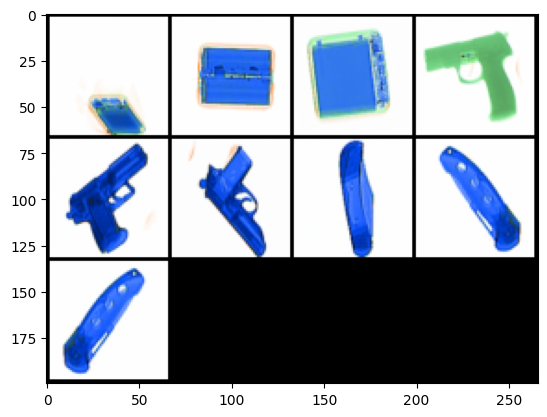

In [41]:
import matplotlib.pyplot as plt
plt.imshow(out)

In [8]:
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
from diffusers.utils import randn_tensor
import torchvision
from PIL import Image
from io import BytesIO
import glob
import random
from torchvision.utils import make_grid

In [9]:
# output_type = "tensor"
# guidance_scale = 1.0
noisy_latents = randn_tensor(
    (9, 3, 256, 256),
    device="cuda",
    dtype=torch.float32,
)

image = [
    torchvision.transforms.ToTensor()(img.resize((256, 256)))
    for img in output["images"]
]
# image[0]

image = torch.stack([img for img in image])
image = image * 2 - 1
image = image.to(device="cuda", dtype=torch.float32)

In [10]:
sr_unet = UNet2DModel.from_pretrained(
    "results/bean_sr_64to256/checkpoint-32000/unet_ema"
)
sr_unet.load_state_dict(torch.load("results/bean_sr_64to256/unet.pt"))
sr_unet = sr_unet.to(device="cuda")

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 32000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [11]:
noise_scheduler = DDIMScheduler(2000, 0.00085, 0.012, "scaled_linear")
num_inference_steps = 200
eta = 0.0
noise_scheduler.set_timesteps(num_inference_steps, device="cuda")
timesteps_tensor = noise_scheduler.timesteps

In [12]:
with torch.no_grad():
    for t in tqdm(noise_scheduler.timesteps):
        model_output = sr_unet(
            torch.cat([noisy_latents, image], dim=1),
            timestep=t.unsqueeze(0).to(image.device),
        ).sample
        noisy_latents = noise_scheduler.step(
            model_output,
            t,
            noisy_latents,
            eta=eta,
        ).prev_sample
    
image_sr = noisy_latents

100%|██████████| 200/200 [00:21<00:00,  9.50it/s]


In [13]:
noisy_latents = noisy_latents * 0.5 + 0.5
noisy_latents = noisy_latents.clamp(0, 1).cpu()

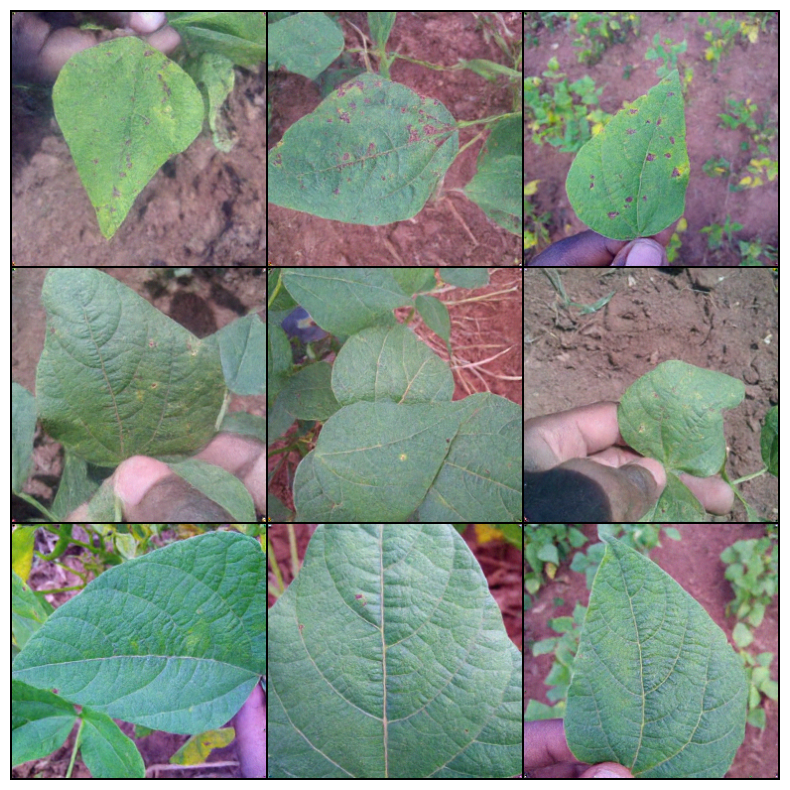

In [14]:
# step=200 eta=0.
plt.figure(figsize=(10, 10))
plt.imshow(
    make_grid(noisy_latents.cpu(), nrow=3).permute(1, 2, 0).numpy(),
)
plt.axis("off")
plt.show()

In [16]:
unet_refine = UNet2DModel.from_pretrained("results/bean_refine/checkpoint-32000/unet_ema")
unet_refine.load_state_dict(torch.load("results/bean_refine/unet.pt"))
unet_refine = unet_refine.to("cuda")


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 32000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [17]:
noise_scheduler = DDIMScheduler(2000, 0.00085, 0.012, "scaled_linear")
num_inference_steps = 200
eta = 0.0
noise_scheduler.set_timesteps(num_inference_steps, device="cuda")
timesteps_tensor = noise_scheduler.timesteps

In [18]:
# output_type = "tensor"
# guidance_scale = 1.0
noisy_latents = randn_tensor(
    (9, 3, 256, 256),
    device="cuda",
    dtype=torch.float32,
)



image = image_sr.to("cuda")


In [19]:
with torch.no_grad():
    for t in tqdm(noise_scheduler.timesteps):
        model_output = sr_unet(
            torch.cat([noisy_latents, image], dim=1),
            timestep=t.unsqueeze(0).to(image.device),
        ).sample
        noisy_latents = noise_scheduler.step(
            model_output,
            t,
            noisy_latents,
            eta=eta,
        ).prev_sample
    

100%|██████████| 200/200 [00:21<00:00,  9.51it/s]


In [20]:
noisy_latents = noisy_latents * 0.5 + 0.5
noisy_latents = noisy_latents.clamp(0, 1).cpu()

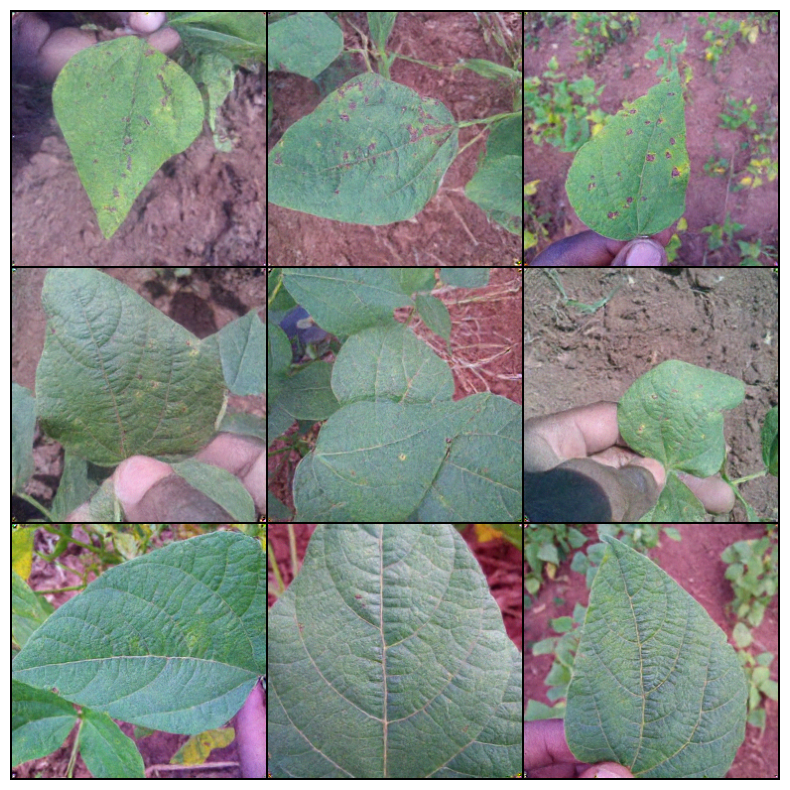

In [21]:
# step=200 eta=0.5
plt.figure(figsize=(10, 10))
plt.imshow(
    make_grid(noisy_latents.cpu(), nrow=3).permute(1, 2, 0).numpy(),
)
plt.axis("off")
plt.show()